# Case 3.  Drug Text Analysis
**Neural Networks for Machine Learning Applications**  
11.3.2022  
Team G03: Eric Keränen - Samuel Aitamaa - Teemu Luhtanen  
Metropolia University of Applied Sciences

## 1. Introduction

This report shows the data preprocessing, modeling, training, evaluating and displaying the results of a neural network based on [UCI ML Drug Review dataset (Kaggle)](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018).

The main objectives of this project is to classify whether a drug review is negative, neutral or positive based on a written text. Our aim was to use the methods of text processing and to experiment with recurrent and convolutional (1D) neural networks to create a classifier for a collection of patient drug reviews extracted from Drugs.com.

We intend to answer to answer the question **"Can you predict the rating of the drug based on the review?"** at the end of the notebook.

## 2. Setup

We used a number of different models, such as matplotlib, pandas and sklearn. For the neural network we used <code>Tensorflow Keras</code> and in the preprocessing section we made use of <code>NLTK</code>, <i>Natural Language Toolkit</i> library.

In [1]:
# Import libraries
%pylab inline
import time
import pandas as pd
import seaborn as sns
import tensorflow as tf
import nltk
import re

# Import functions
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

# Set the size of plots to a large size and dataframe string limitation to none
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_colwidth', None)

# Tensorflow version number
print(f"Tensorflow version: {tf.__version__}")

# Download popular NLTK tools
nltk.download("popular", quiet=True)

Populating the interactive namespace from numpy and matplotlib
Tensorflow version: 2.7.0


True

## 3. Dataset

This dataset consists of over 200 000 drug reviews from [Drugs.com](https://www.drugs.com). It was originally published UCI Machine Learning repository and is now publicly available in [Kaggle.com](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018). Citation:

> Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125.

The dataset consists of written reviews as well as a numerical rating for the drug. They also have <code>usefulCount</code>, which tells how many other users have voted the review to be useful. In addition to these they have ID, drug's name, condition and date.

### 3.1 Exploring the dataset

In [2]:
df_train = pd.read_csv("drugsComTrain_raw.csv", na_values = "?")
df_test = pd.read_csv("drugsComTest_raw.csv", na_values = "?")
df_train.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.""",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp; hurt! Leg/ankles aches severe lower bowel preassure like you need to go #2 but can&#039;t! Enjoyed the initial rockhard erections but not at these side effects or $230 for months supply! I&#039;m 50 &amp; work out 3Xs a week. Not worth side effects!""",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I took the Plan B 26 hours later, and took a pregnancy test two weeks later - - I&#039;m pregnant.""",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage. My moods were out of c

The dataset consists of seven columns:

|Column name|Meaning|Type|
|---|:---:|:---:|
|uniqueID|ID of the review|Numerical|
|drugName|Name of the reviewed drug|String|
|condition|Diagnose of the patient|String|
|review|Text review for the drug|String|
|rating|Rating for the drug by reviewer|Numerical|
|date|Date of the review|Date|
|usefulCount|Upvotes of the review|Numerical|

In the train set we have 161 297 reviews which is 80% of the whole dataset at this point. In the next section we will further divide it into a train and validation sets.

In [3]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
uniqueID,161297.0,115923.585305,67004.445170,2.0,58063.0,115744.0,173776.0,232291.0
rating,161297.0,6.994377,3.272329,1.0,5.0,8.0,10.0,10.0
usefulCount,161297.0,28.004755,36.403742,0.0,6.0,16.0,36.0,1291.0


## 4. Preprocessing

Preprocessing text is vital in a text classification analysis, since text in its original form cannot be fed into a neural network. In this chapter we will cover, how we preprocessed the drug reviews, so that they can be processed by a neural network.

### 4.1 Splitting and extracting data

Firstly we extract labels and features from the data. We extract only reviews (features) and ratings (labels), since we do not need anything else. That means that columns like "date" and "usefulCount" were entirely dropped out.

We also split the training data into training and validation. Training data will be 70 % of the original training data and validation will be 30 % of the original training data. Test data came from a separate file, so it won't be splitted.

In [4]:
# Extract train labels and train features from train data
train_features = df_train['review']
train_labels = df_train['rating']

# Split training data into 70 % training data and 30 % validation data
train_features, val_features, train_labels, val_labels = split(train_features, train_labels, test_size = 0.30, train_size = 0.70, random_state = 0)

# Extract test labels and test features from test data
test_features = df_test['review']
test_labels = df_test['rating']

From the shapes of the features we can see that we have 112 907 observations for training, 48 390 observations for validation and 53 766 observations for testing.

In [5]:
print (train_features.shape)
print (val_features.shape)
print (test_features.shape)

(112907,)
(48390,)
(53766,)


### 4.2 Missing values

After extracting features and labels, we check that are there any missing values. From the prints, we can see that nothing is null meaning nothing is missing.

In [6]:
print(f"Missing train features: {train_features.isnull().sum()}")
print(f"Missing validation features: {val_features.isnull().sum()}")
print(f"Missing test features: {test_features.isnull().sum()}")

Missing train features: 0
Missing validation features: 0
Missing test features: 0


In [7]:
print(f"Missing train labels: {train_labels.isnull().sum()}")
print(f"Missing validation labels: {val_labels.isnull().sum()}")
print(f"Missing test labels: {test_labels.isnull().sum()}")

Missing train labels: 0
Missing validation labels: 0
Missing test labels: 0


### 4.3 Simplifying labels

We were also tasked to convert the ratings from a scale of 1-10 to a scale of either "positive", "neutral" or "negative". This scale was taken from an article by Felix Gräßer et al. where the ratings were change by the following rules:

> rating ≤ 4 = -1  
> 4 < rating < 7 = 0  
> rating ≥ 7 = 1  

We decided to make a slight variation of this, where our rating would go like so:

> rating ≤ 4 = 0   
> 4 < rating < 7 = 1  
> rating ≥ 7 = 2

With this kind of values we can easily one-hot encode the ratings (labels).

In [8]:
def convert_to_categorical(data):
    replaced = data.replace(
        {
            1: 0, # negative
            2: 0, # negative
            3: 0, # negative
            4: 0, # negative
            5: 1, # neutral
            6: 1, # neutral
            7: 2, # positive
            8: 2, # positive
            9: 2, # positive
            10: 2 # positive
        }
    )
    
    return replaced

We make a check that the labels really are between 0 and 2.

In [9]:
train_labels = convert_to_categorical(train_labels)
val_labels = convert_to_categorical(val_labels)
test_labels = convert_to_categorical(test_labels)

print (f"Train labels: \nMax: {train_labels.max()}\nMin: {train_labels.min()}")
print (f"Validation labels: \nMax: {val_labels.max()}\nMin: {val_labels.min()}")
print (f"Test labels: \nMax: {test_labels.max()}\nMin: {test_labels.min()}")

Train labels: 
Max: 2
Min: 0
Validation labels: 
Max: 2
Min: 0
Test labels: 
Max: 2
Min: 0


The labels have been converted to three different numerical values. In addition to this conversion, we want to one-hot encode the labels. This way instead of having the number "2" represent positive reviews, we represent positive reviews with \[0. 0. 1.\].

In [10]:
# One-hot encode labels
train_cat = to_categorical(train_labels, 3)
val_cat = to_categorical(val_labels, 3)
test_cat = to_categorical(test_labels, 3)

print (train_cat[0])

[0. 0. 1.]


From now on we will use these variables suffixed with "\_cat" as labels.

### 4.4 Imbalance and Weights

We check how the ratings are distributed in the training set. We can see that in training set, ~66 % of the reviews are positive, ~9 % are neutral and ~25 % are negative. This means that neutral reviews are at a massive disadvantage compared to negativbe and positive reviews. To tackle this imbalance in the reviews, we generate weights according to which the neural network will "pay more attention" to the labels with bigger weights.

In [11]:
negative_count, neutral_count, positive_count = np.bincount(train_labels)
total = negative_count + neutral_count + positive_count

print(f"Positive review amount: {round(100 * positive_count / total, 2)} %")
print(f"Neutral review amount: {round(100 * neutral_count / total, 2)} %")
print(f"Negative review amount: {round(100 * negative_count / total, 2)} %")

Positive review amount: 66.29 %
Neutral review amount: 8.91 %
Negative review amount: 24.8 %


We generate weights for the classes using the formula from [Tensorflows classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) notebook.

In [12]:
# Because of the imbalance, create weights for the labels
positive_weight = 1 / positive_count * (total / 2.0)
neutral_weight = 1 / neutral_count * (total / 2.0)
negative_weight = 1 / negative_count * (total / 2.0)
class_weight = {0: negative_weight, 1: neutral_weight, 2: positive_weight}

print(f"Positive weight: {round(positive_weight, 2)}")
print(f"Neutral weight: {round(neutral_weight, 2)}")
print(f"Negative weight: {round(negative_weight, 2)}")

Positive weight: 0.75
Neutral weight: 5.61
Negative weight: 2.02


We can see that the neutral reviews indeed have the biggest weight, with the next biggest being calculated for negative reviews. Positive reviews will be paid less attention, since they have to most presence in the data.

### 4.5 Text cleaning

As the next big preprocessing step is the cleaning of the text itself. We drew inspirations on how to clean the text from our [Methods courses](https://github.com/Mahamurahti/Python-Neural-Network-Exercises/blob/main/Methods/Methods_Exercises_07.ipynb) and from a [text classification notebook](https://www.kaggle.com/chocozzz/recommendation-medicines-by-using-a-review) by [Seaotter](https://www.kaggle.com/chocozzz). Here we start to use <code>NLTK</code>-library, which we imported at the beginning of the notebook. We define a couple of functions, that do specific thing to the text.

Firstly we define a function, that removes english stopwords from the text. Stopwords are words that occur very often in any texts, like "a", "the" and "I".

In [13]:
def remove_stopwords(data):
    stops = set(stopwords.words('english'))
    not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
                "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
    
    for word in not_stop:
        stops.remove(word)
        
    meaningful_words = [word for word in data if not word in stops]
    return meaningful_words

Then we define a function that lemmatizes the words of the text. Lemmatization means converting the word into its base form while taking into account the context. Another technique we could've used is stemming, but decided that lemmatization was better. The difference between stemming and lemmatization is that lemmatization considers the context and converts the word to its meaningful base form. Stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

>"Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form."  
> [Wikipedia, Lemmatization](https://en.wikipedia.org/wiki/Lemmatisation)

In [14]:
def lemmatize(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in data]
    
    return lemmatized_words

We define one more function which is the main function for cleaning the text. The text cleaning goes as follows:

1. Remove HTML from text
2. Delete everything but letters from the text
3. Lower case all letters and split sentences into words (makes a list of words)
4. Remove stopwords from the list of words
5. Lemmatize the words
6. Join the words into sentences again
7. Save the sentences

In [15]:
def clean_text(data, array):
    for sample in data:
        # Remove HTML from text
        non_html_text = BeautifulSoup(sample, 'html.parser').get_text()
        # Leave only letters in text
        letters_only = re.sub('[^a-zA-Z]', ' ', non_html_text)
        # Lower case and split text into words
        words = letters_only.lower().split()
        # Remove stopwords
        meaningful_words = remove_stopwords(words)
        # Lemmatize words
        lemmatized_words = lemmatize(meaningful_words)
        # Make into whole text again
        cleaned_review = ' '.join(lemmatized_words)
        # Save review
        array.append(cleaned_review)

Then we conduct the cleaning itself, for every dataset.

In [16]:
train_features_clean = []
val_features_clean = []
test_features_clean = []

print ("Reviews of unprocessed samples:\n")
print (train_features.iloc[:1].to_string(index = False), "\n")
print (val_features.iloc[:1].to_string(index = False), "\n")
print (test_features.iloc[:1].to_string(index = False), "\n")
    
clean_text(train_features, train_features_clean)
clean_text(val_features, val_features_clean)
clean_text(test_features, test_features_clean)
        
print ("Reviews of processed samples:\n")
print (train_features_clean[0], "\n")
print (val_features_clean[0], "\n")
print (test_features_clean[0], "\n")

Reviews of unprocessed samples:

"I was able to breathe finally. I had always been out of breath. All day. When I started taking Symbicort, I could breathe. And I would&#039;ve been able to clean, and play with my kids, go for a walk, excercise. However, I stopped taking it. The side effects were horrible. I was angry, on edge. Worst constant headache ever! It wasn&#039;t fair to my family. Waiting to find an alternative." 

"I recently received an injection of nalbuphine in a walk-in/non-life threatening ER for a cluster headache that had spiked to a 10 on the pain scale and it was an absolute revelation to me. With negligible side effects, it worked as well (10 to 6 on pain scale) as 4 times the typical IV injection of Dilaudid (so 4mg or about 16-24mg oral/60-80mg of oral morphine/100-150mcg of transdermal fentanyl/150-200mg of oral Demerol) without making me high or nod out. This was the first partial agonist (like buprenorphine) that actually helped severe pain. " 

"I&#039;ve tri

Above we can see some unprocessed samples and processed samples. From the unprocessed samples we can see that we have normal text with some HTML, numbers and special characters sprinkled into the mix. The HTML is processed out of the text using a library called [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#), which is meant for pulling data out of HTML and XML files. We can see that we don't have any <code>\&amp;</code> markings in the processed text. The processed text also has no special characters or numbers, since they have been removed using [Regex](https://regexr.com/). Stopwords have been removed and words have been lemmatized with [NLTK](https://www.nltk.org/) library and only meaningful words remain.

### 4.6 Tokenization and Sequencing

After cleaning the text we move to transforming the text into a format that is understandable by neural networks; numbers. We start this transformation by fitting the cleaned texts into the tokenizer, that will take into account 4096 (<code>NUMBER_OF_WORDS</code>) most frequent words from the cleaned reviews. Next we transform the most frequent words into sequences (numbers) and pad the sequences so that every sequence has the same number of numbers. We set this number to 128 (<code>SEQUENCE_LENGTH</code>). This process is done to every set (train, validation and test).

In [17]:
NUMBER_OF_WORDS = 4096
SEQUENCE_LENGTH = 128

# How many of the most frequent words will be taken into account
tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)

tokenizer.fit_on_texts(train_features_clean)
train_sequences = tokenizer.texts_to_sequences(train_features_clean)
train_features = pad_sequences(train_sequences, maxlen = SEQUENCE_LENGTH)

tokenizer.fit_on_texts(val_features_clean)
val_sequences = tokenizer.texts_to_sequences(val_features_clean)
val_features = pad_sequences(val_sequences, maxlen = SEQUENCE_LENGTH)

tokenizer.fit_on_texts(test_features_clean)
test_sequences = tokenizer.texts_to_sequences(test_features_clean)
test_features = pad_sequences(test_sequences, maxlen = SEQUENCE_LENGTH)

We check what the shapes look like now and it seems everything has gone smoothly. We have the same amount of observations on the sets as we had on chapter 4.1 and we can also see that every feature array is of the same max length (128).

In [18]:
print (train_features.shape)
print (val_features.shape)
print (test_features.shape)

(112907, 128)
(48390, 128)
(53766, 128)


### 4.7 Summary of preprocessing

We started off preprocessing by checking <code>NaN</code> values and then split the data into train, test and validation sets. We <i>lemmatized</i> the words and deleted <i>stop words</i>, <i>tokenized</i> them and added <i>sequence paddings</i>. We also simplified the numerical labels (1-10) into <i>positive</i> (7-10), <i>neutral</i> (5-6) and <i>negative</i> (1-4). Next we intend to experiment with three types of neural networks using, <code>LSTM</code>, <code>GRU</code> and <code>Conv1D</code> layers from the <code>Tensorflow Keras</code> library and lastly evaluate them and display the results.

## 5. Modeling

After preprocessing, we created three models with different parameters. We decided to test <code>LSTM</code>, <code>GRU</code> and <code>Conv1D</code> models. All the models are <code>Sequential</code> from the <code>Tensorflow Keras</code> library. Later in this document we will evaluate each model for research purposes and choose the best one as the final model. We decided to use smaller models to reduce overfitting which was huge at the start and make the runtimes much faster.

All of our models included an <code>Embedding</code>-layer with <code>input_dim</code> set to 4096 (<code>NUMBER_OF_WORDS</code>). Also <code>output_dim</code> was set to 64 (<code>EMBEDDING_DIMENSION</code>) and <code>input_length</code> was set to 128 (<code>SEQUENCE_LENGTH</code>). 

After the <code>Embedding</code>-layer, every model had a <code>SpatialDropout1D</code>-layer which functions the same way as a normal dropout layer but it drops entire 1D feature maps instead of individual elements. <code>SpatialDropout1D</code>-layers' <code>rate</code> was set to 0.1.

> "If adjacent frames within feature maps are strongly correlated then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead."
>
> [Keras, SpatialDropout1D layer](https://keras.io/api/layers/regularization_layers/spatial_dropout1d/)


Other layers varied a little depending of a model (specified later for each model separately) but every model ended with <code>Dense</code>-layer. Last <code>Dense</code>-layer had neurons set to 3 and <code>softmax</code> was used as an activation function. <code>Softmax</code> is used as the activation function for multi-class classification problems, where class membership is required on more than two class labels.

In [19]:
three_models = []

EMBEDDING_DIMENSION = 64

### 5.1 Model one

In the first model we used one <code>LSTM</code>-layer with 16 neurons and <code>dropout</code>/<code>recurrent_dropout</code> was set to 0.3.

> "Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems."
>
> [Jason Brownlee, A Gentle Introduction to Long Short-Term Memory Networks by the Experts](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/)

In [20]:
def make_model_one():  
    model = models.Sequential([
        layers.Embedding(NUMBER_OF_WORDS, EMBEDDING_DIMENSION, input_length = SEQUENCE_LENGTH),
        layers.SpatialDropout1D(0.1),
        layers.LSTM(16, dropout = 0.3, recurrent_dropout = 0.3),
        layers.Dense(3, activation = "softmax")
    ])
    
    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.CategoricalCrossentropy(),
        metrics = [
            metrics.CategoricalAccuracy(name = 'acc'),
        ]
    )
    
    return model

three_models.append(make_model_one())
three_models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           262144    
                                                                 
 spatial_dropout1d (SpatialD  (None, 128, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 267,379
Trainable params: 267,379
Non-trainable params: 0
_________________________________________________________________


### 5.2 Model two

In the second model we used one <code>GRU</code>-layer with 16 neurons and <code>dropout</code>/<code>recurrent_dropout</code> was set to 0.3.

> "The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate."
>
> [Michael Phi, Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

In [21]:
def make_model_two():    
    model = models.Sequential([
        layers.Embedding(NUMBER_OF_WORDS, EMBEDDING_DIMENSION, input_length = SEQUENCE_LENGTH),
        layers.SpatialDropout1D(0.1),
        layers.GRU(16, dropout = 0.3, recurrent_dropout = 0.3),
        layers.Dense(3, activation = "softmax")
    ])
    
    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.CategoricalCrossentropy(),
        metrics = [
            metrics.CategoricalAccuracy(name = 'acc'),
        ]
    )
    
    return model

three_models.append(make_model_two())
three_models[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 64)           262144    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 128, 64)          0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 16)                3936      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 266,131
Trainable params: 266,131
Non-trainable params: 0
_________________________________________________________________


### 5.3 Model three

In the third model we used one <code>Conv1D</code>-layer followed by <code>GlobalAveragePooling1D</code>-layer. <code>Conv1D</code>-layer had neurons set to 128, <code>kernel_size</code> to 7, <code>padding</code> to valid, <code>strides</code> to 3 and ReLu was used as an activation function.

Before the last <code>Dense</code>-layer, we used another <code>Dense</code>-layer with 128 neurons and <code>ReLu</code> activation function. After that we also had <code>Dropout</code>-layer with value set to 0.3.

In [22]:
def make_model_three():    
    model = models.Sequential([
        layers.Embedding(NUMBER_OF_WORDS, EMBEDDING_DIMENSION, input_length = SEQUENCE_LENGTH),
        layers.SpatialDropout1D(0.1),
        layers.Conv1D(128, 7, padding = "valid", strides = 3, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation = "relu"),
        layers.Dropout(0.3),
        layers.Dense(3, activation = "softmax")
    ])
    
    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.CategoricalCrossentropy(),
        metrics = [
            metrics.CategoricalAccuracy(name = 'acc'),
        ]
    )
    
    return model

three_models.append(make_model_three())
three_models[2].summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 64)           262144    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 128, 64)          0         
 lDropout1D)                                                     
                                                                 
 conv1d (Conv1D)             (None, 41, 128)           57472     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)              

## 6. Training

In this section we trained all of our three models using the same data <code>train_features</code> and labels <code>train_cat</code>.

### 6.1 Epochs and batch size

We tried a few different options for <code>BATCH_SIZE</code> and <code>EPOCHS</code>. We found out that the computing times for each model is relatively high, so we decided to keep these values, especially <code>EPOCHS</code> as modest. They didn't seem to affect the results drastically and thus we put most of our focus on different hyperparameters, such as the number of <i>hidden layers</i>.

As the <code>BATCH_SIZE</code> we decided to go with 64 to make runtimes faster and for <code>EPOCHS</code> we decided to go with a strudy 10 to not make the training too long with recurrent neural network models.

In [23]:
EPOCHS = 10
BATCH_SIZE = 64

histories = []

Below we conduct the training itself. Each training is timed with the time library.

In [24]:
for model in three_models:
    print (f"Training model {three_models.index(model) + 1} now")
    
    t0 = time.time()
    
    history = model.fit(
        train_features,
        train_cat, 
        epochs = EPOCHS, 
        batch_size = BATCH_SIZE,
        verbose = 1,
        validation_data = (val_features, val_cat),
        class_weight = class_weight
    )
    
    t1 = time.time()
    
    etime = t1 - t0
    print(f"Total elapsed time {etime:.2f} s and {etime / EPOCHS:.3f} s/epoch")
    
    histories.append(history)

Training model 1 now
Epoch 1/10
1765/1765 [==============================] - 108s 60ms/step - loss: 1.3390 - acc: 0.6530 - val_loss: 1.1738 - val_acc: 0.3973
Epoch 2/10
1765/1765 [==============================] - 106s 60ms/step - loss: 1.2531 - acc: 0.6628 - val_loss: 1.0475 - val_acc: 0.5225
Epoch 3/10
1765/1765 [==============================] - 105s 59ms/step - loss: 1.2239 - acc: 0.6687 - val_loss: 1.1288 - val_acc: 0.4590
Epoch 4/10
1765/1765 [==============================] - 105s 59ms/step - loss: 1.2005 - acc: 0.6770 - val_loss: 1.1729 - val_acc: 0.4150
Epoch 5/10
1765/1765 [==============================] - 104s 59ms/step - loss: 1.1800 - acc: 0.6836 - val_loss: 1.0688 - val_acc: 0.5311
Epoch 6/10
1765/1765 [==============================] - 103s 58ms/step - loss: 1.1620 - acc: 0.6896 - val_loss: 1.1932 - val_acc: 0.4508
Epoch 7/10
1765/1765 [==============================] - 104s 59ms/step - loss: 1.1516 - acc: 0.6935 - val_loss: 1.0541 - val_acc: 0.5325
Epoch 8/10
1765/1765

## 7. Performance and evaluation

In this chapter we evaluate the performance of each model individually.

### 7.1 Evaluation

For evaluation we created two functions. The function <code>show_history</code> shows the history of the model in a plot and the final metrics (accuracy and loss). The second function <code>show_results</code> shows the results of the model using a **test set**. We print out the classification report, confusion matrix and cohens kappa score that the trained model gives when evaluating on the test set.

In the results we decide which model is the best depending on the **accuracy and cohens kappa score**.

In [34]:
# Plot the accuracy and loss
def show_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    e = np.arange(len(acc)) + 1

    plt.figure()
    plt.plot(e, acc, '-', label = 'train')
    plt.plot(e, val_acc, '--', label = 'validation')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(e, loss, '-', label = 'train')
    plt.plot(e, val_loss, '--', label = 'validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()

    plt.show()
    print (f"Train Accuracy : {acc[-1]}")
    print (f"Train Loss : {loss[-1]}")
    print (f"Validation Accuracy : {val_acc[-1]}")
    print (f"Validation Loss : {val_loss[-1]}")

As we try to pick the best model depending on cohens kappa score (as well as accuracy) we needed some rules on how to interpret the score. We decided to go with the rules provided by [Landis and Koch](https://en.wikipedia.org/wiki/Cohen%27s_kappa).

>Kappa value interpretation Landis & Koch (1977):  
><0 No agreement  
>0 — .20 Slight  
>.21 — .40 Fair  
>.41 — .60 Moderate  
>.61 — .80 Substantial  
>.81–1.0 Perfect  
>
> [Researchgate, Cohens Kappa](https://www.researchgate.net/figure/Cohens-Kappa-Landis-Koch-1977_tbl2_220209810)

In [42]:
# Show classification report, confusion matrix and cohens kappa of given model
def show_results(model):
    results = model.evaluate(test_features, test_cat, batch_size = BATCH_SIZE)
    
    predictions = np.argmax(model.predict(test_features), axis = 1)
    
    print (f"Classification report")
    print (classification_report(test_labels, predictions))
    
    cm = confusion_matrix(test_labels, predictions)
    cm = pd.DataFrame(cm)
    plt.figure(figsize = (10,5))
    sns.heatmap(cm, cmap = "rocket_r", linecolor = "black", annot = True, fmt = "")
    
    k = cohen_kappa_score(test_labels, predictions)
    print(f"Cohen's kappa (linear) = {k:.4f}")

### 7.2 Evaluating the first model

Below we can see the training process of the first model. Training accuracy is a solid 70 % but validation accuracy is a fair bit lower at about 52 %. The accuracies are not so good. Loss of the first model makes a steady decline into a value of ~1.1 at the last epoch. The good thing about validation loss is that it stays under training loss for most of the time, which is an excellent indication that there is no overfitting. Validation epoch stops to around ~1 at the last epoch.

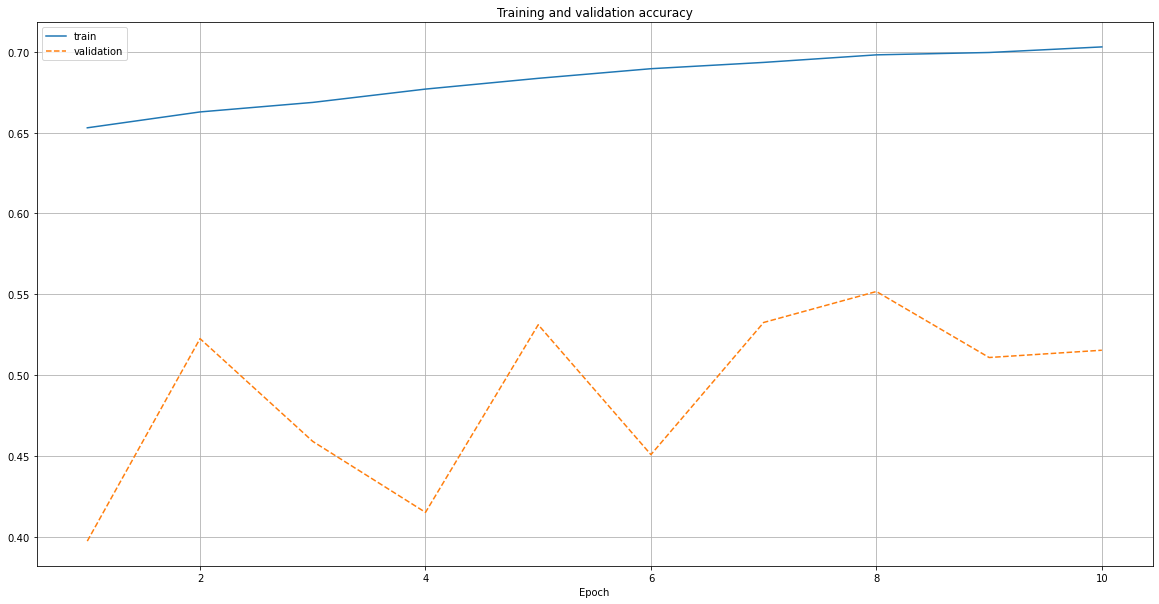

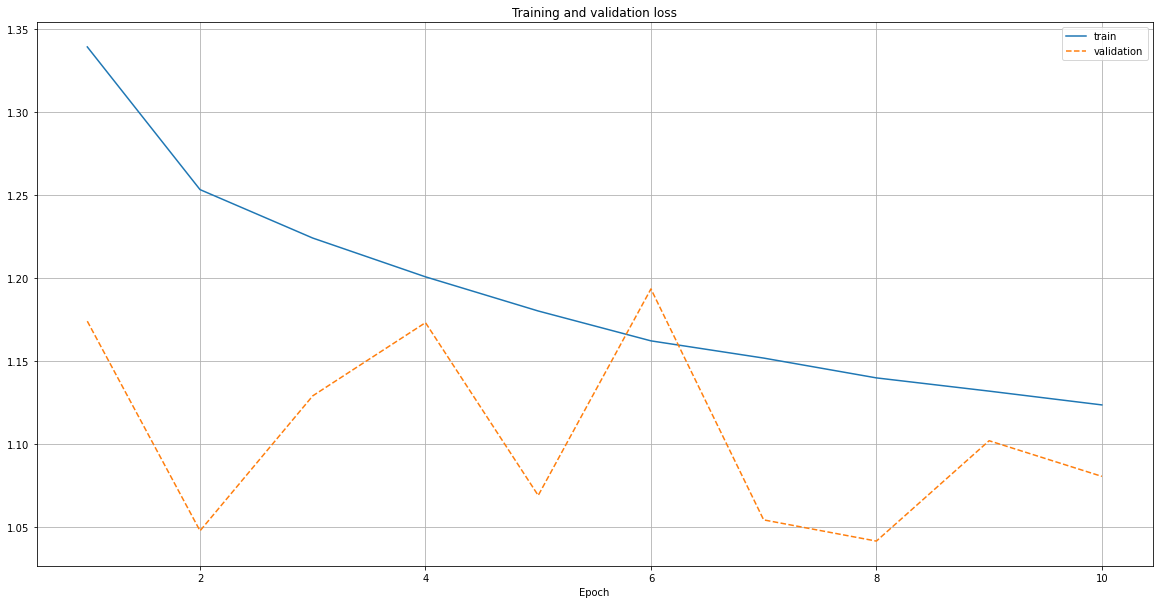

Train Accuracy : 0.7030653357505798
Train Loss : 1.1233794689178467
Validation Accuracy : 0.5153750777244568
Validation Loss : 1.0803334712982178


In [43]:
show_history(histories[0])

Evaluating the first model on the test set reveal that the accuracy is just 50 %, which is not good. This means that of all the test cases, the first trained model managed to classify 50 % correct. This accuracy would be abysmally bad in a binary classification, but we though that it is relatively okay in multiclass classification with the use of weights (even though it really is quite horrendous). The first model got 4327 of 13497 of the negative reviews correct, 1637 of 4829 of the neutral reviews correct and 21059 of 35440 of the positive reviews correct. Even though positive reviews had the lowest weight and neutral reviews had the highest weight, the model still managed to classify positive reviews much more precisely (74 %) than neutral reviews (12 %). Even though the neutral reviews had bad precision, the recall was better (34 %) than with negative reviews (32 %). Positive reviews had the highest recall at 59 %.

841/841 [==============================] - 6s 7ms/step - loss: 1.1138 - acc: 0.5026
Classification report
              precision    recall  f1-score   support

           0       0.38      0.32      0.35     13497
           1       0.12      0.34      0.17      4829
           2       0.74      0.59      0.66     35440

    accuracy                           0.50     53766
   macro avg       0.41      0.42      0.39     53766
weighted avg       0.60      0.50      0.54     53766

Cohen's kappa (linear) = 0.1364


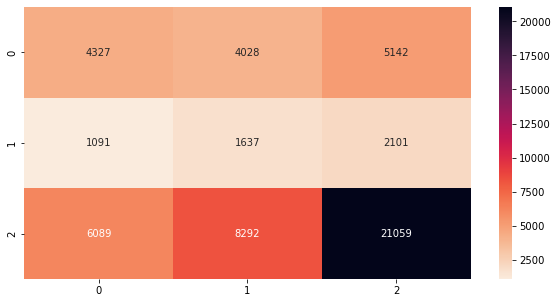

In [44]:
show_results(three_models[0])

Cohens kappa of the first model was 0.13, which would be only slight agreement according to the kappa value interpretations by Landis and Koch. This value is also bad, but on par with the other metrics that have come out of this model.

### 7.3 Evaluating the second model

The second model used a <code>GRU</code> layer. We can see that the results are quite similiar to the first model, validation accuracy staying relatively low at around 50%. The training curve manages to reach over 70%, but unfortunately the poor results of the validation set makes it somewhat irrelevant. Validation loss is in a similiar level too, staying below the training loss. This means that atleast the model is not overfitting too much during the 10 epochs.

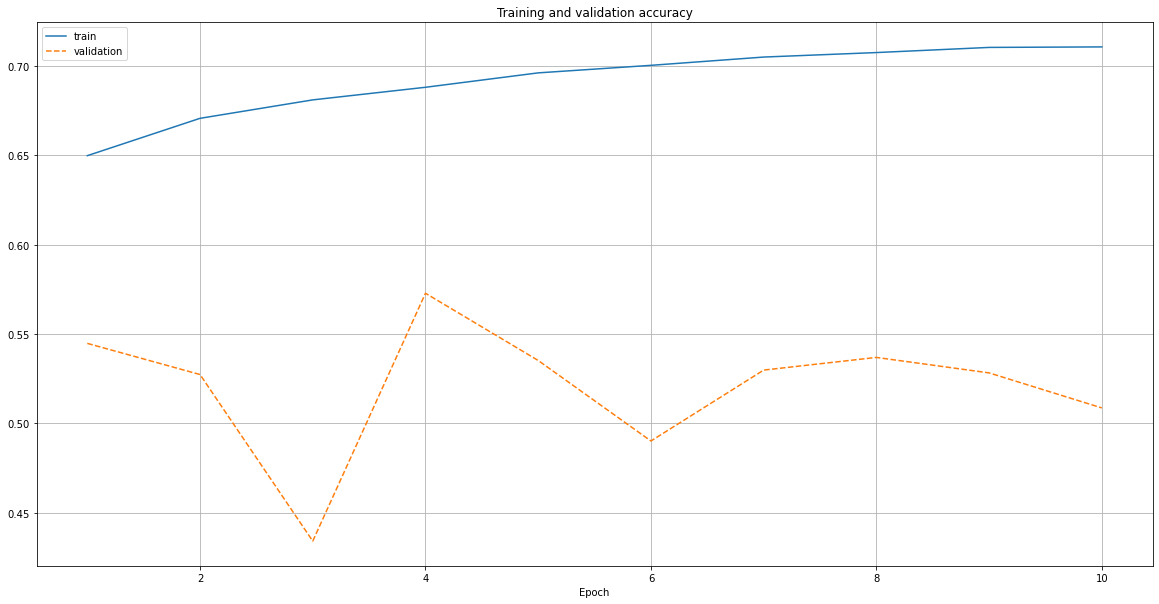

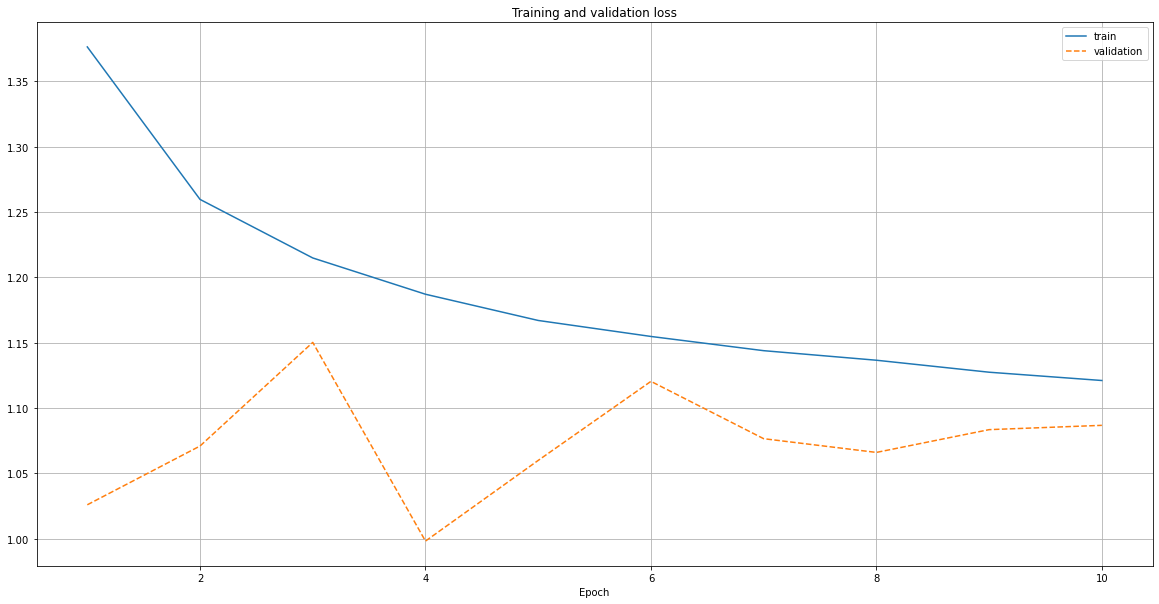

Train Accuracy : 0.7106202244758606
Train Loss : 1.121075987815857
Validation Accuracy : 0.5086588263511658
Validation Loss : 1.0867798328399658


In [45]:
show_history(histories[1])

The test set gives an accuracy of around 50% with validation set, similiar to the first model. Each set's (train, test and validation) results, resemble each other between model one and two. No major improvements or downsides can be observed between the models that use <code>LSTM</code> and <code>GRU</code> layers. We didn't manage to find impressive results with either of these and tweaking the hyperparameters didn't achieve the results we were hoping to see.

841/841 [==============================] - 8s 9ms/step - loss: 1.1098 - acc: 0.4998
Classification report
              precision    recall  f1-score   support

           0       0.39      0.28      0.32     13497
           1       0.11      0.34      0.17      4829
           2       0.74      0.61      0.66     35440

    accuracy                           0.50     53766
   macro avg       0.41      0.41      0.39     53766
weighted avg       0.59      0.50      0.53     53766

Cohen's kappa (linear) = 0.1257


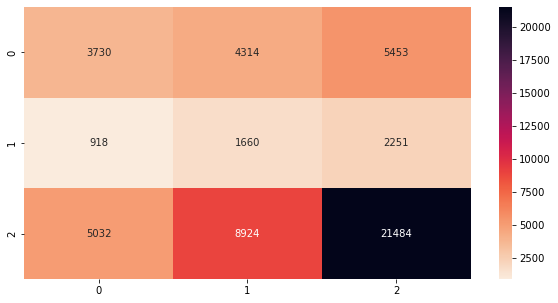

In [46]:
show_results(three_models[1])

Cohens kappa score is only slightly lower than the first models, sitting at around 0.125.

### 7.4 Evaluating the third model

Below you can see the training of the third model. Training accuracy is about 70-75 % all the time, but
validation accuracy starts from ~58 % and lowers pretty much during the training, ending down to ~36 %
in tenth epoch which is not good at all. From this we can already predict that the model is overfitting.
Training loss starts from ~1.4 and lowers as it should, ending up to ~0.9 at the tenth epoch. Validation
accuracy starts from ~1.0 and raises to ~1.5 at tenth epoch. At this point at the latest we can see
that our model is clearly overfitting.

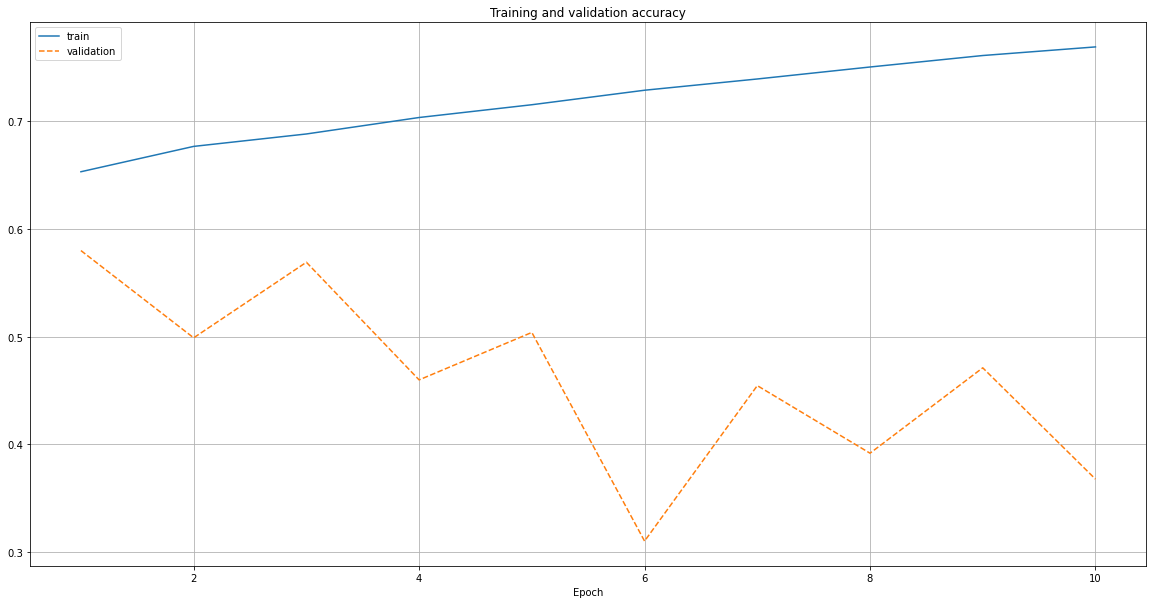

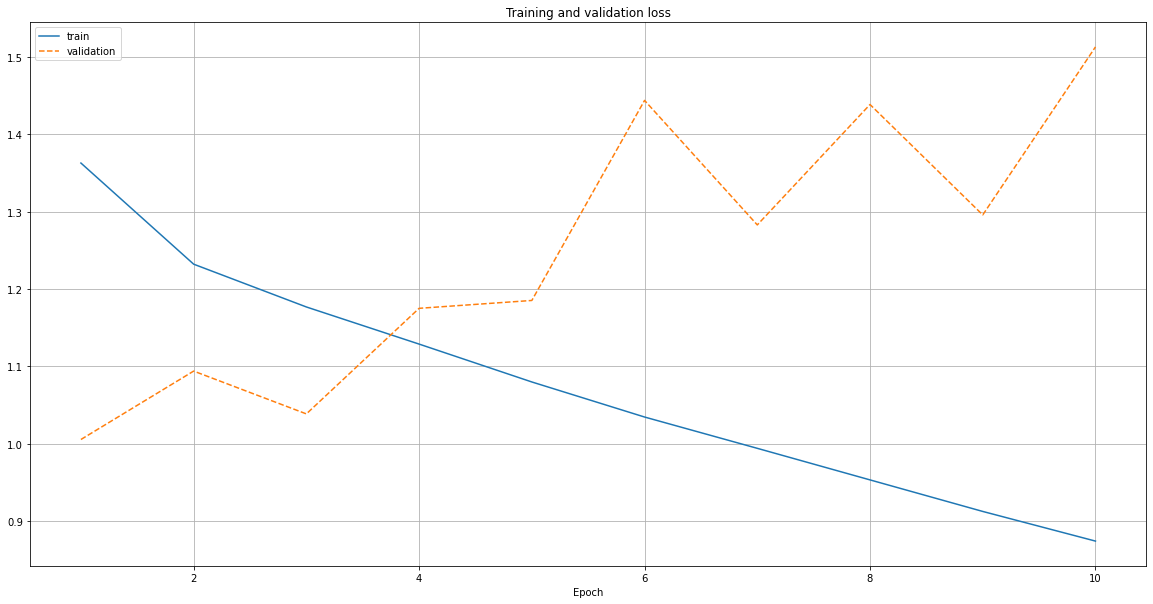

Train Accuracy : 0.7691462635993958
Train Loss : 0.8741441965103149
Validation Accuracy : 0.36749327182769775
Validation Loss : 1.5128865242004395


In [47]:
show_history(histories[2])

Below you can see the classification report and confusion matrix of the third model. Cohen's kappa is
only 0.0768 which is far from the optimal value. Test accuracy was ~36 % which is pretty detestable. In this model we can say that when the model predicts a review as neutral, it is 58 % of the times correct (recall). This recall value is the highest among the models. We can also see that most of the predictions actually went into predicting that the review is a neutral one, since the middle column of the confusion matrix is packed with predictions. This model is the best one of these models, when trying to predict that is a review neutral.

841/841 [==============================] - 2s 2ms/step - loss: 1.5468 - acc: 0.3596
Classification report
              precision    recall  f1-score   support

           0       0.36      0.24      0.29     13497
           1       0.10      0.58      0.17      4829
           2       0.74      0.38      0.50     35440

    accuracy                           0.36     53766
   macro avg       0.40      0.40      0.32     53766
weighted avg       0.59      0.36      0.42     53766

Cohen's kappa (linear) = 0.0768


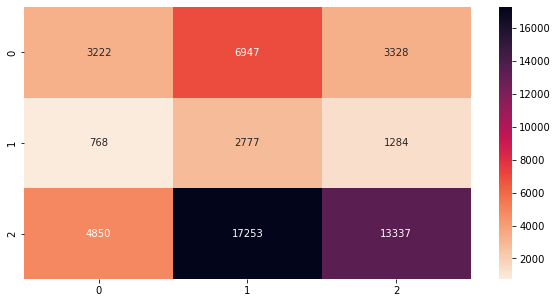

In [48]:
show_results(three_models[2])

We can deduce from these models that this one (the third) was the worst. Since the first and the second
model don't overfit and got better results, we came to a conclusion that RNN models fit better
for text classification problems than convolutional networks.

### 7.5 Performance of chosen model

As the final model we chose **model one**, which had the best accuracy and cohens kappa.

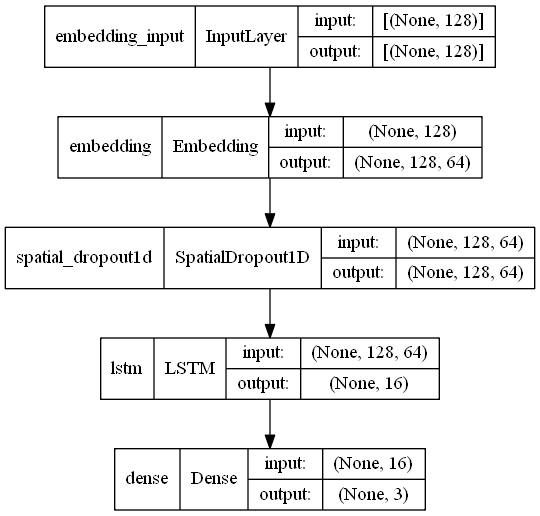

In [50]:
chosen_model = three_models[0]

# Show what kind of layers the chosen model has
tf.keras.utils.plot_model(chosen_model, show_shapes=True, rankdir="TB", dpi="96", to_file="model.png")

The chosen model was a recurrent neural network, with an <code>Embedding</code>-layer and <code>LSTM</code>-layer as the core of the model. The deciding metrics of this model were an **accuracy of 50 % and cohens kappa score of 0.13 (slight agreement)**. Training took 1045 s for this model and 104 s per epoch.

All of our models performed really inadequately even though we tried really hard to get good scores. The main reason we believe we got such dreadful scores will be explained in chapter 8.

### 7.6 Performance comparison

We compare our selected model and its performance to the performance of an article. The article in question is by Felix Gräßer, Surya Kallumadi, Hagen Malberg and Sebastian Zaunseder and is about [Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning](https://kdd.cs.ksu.edu/Publications/Student/kallumadi2018aspect.pdf). We use table 2 on page 204 of this article to compare our results. The table can also be seen below:

![https://i.gyazo.com/4b7af9c9ef45321e775c2de25ac12c3d.png](https://i.gyazo.com/4b7af9c9ef45321e775c2de25ac12c3d.png)

From this table we look at only the first row and its accuracy / kappa score, since all the other rows are from [Druglib.com](http://www.druglib.com/) but our data was only from [Drugs.com](https://www.drugs.com/).

Comparing our model, which got an accuracy of 50 % and cohens kappa score of 0.13, to this table, we can see that the results were inferior by a large margin. Our model got ~42 percentage points lower accuracy than what the authors of the article got. Cohens kappa score was also also 0.71 points lower. This means we were far off from optimal results.

# 8. Discussion and conclusions

To answer the question "Can you predict the rating of the drug based on the review?" the answer would be a simple "No." with our model.

We tested a lot of different settings to find a model that prevents overfitting and manages to get reasonably good results. We tried three different types of model's, first with a <code>LSTM</code> layer, second with <code>GRU</code> layer and the third one with <code>Conv1D</code>. We tried stacking these layers and multiple amount of different neurons, filter sizes and dropout rates. We somewhat managed to overcome overfitting but never got a good <i>Cohen's Kappa</i> value or accuracy. The best Cohen's Kappa value we got was **0.13** and the best test accuracy was **50%**. These values can't be seen as satisfactory for a relevant classifier. With batch size and the number of epochs we also tried different things, but were more restricted on our options with these due to high computing times.

Because the number of neutral reviews is marginal compared to positive and negative, class weights seemed to be a good idea to get a thorough tool for multiclass classification. We tried to train the model with and without class weights and observed that without class weights the model is almost completely unable to classify the neutral reviews. With class weights it managed to find them too, with a cost of overall accuracy. <u>We decided to use weights in our models as the aim was multiclass classification, and without the class weights the results would have been almost the same as running a binary classification tool</u>.

It is also worth to mention that we did not find a single neural network project that does not overfit on this dataset. This makes us believe that a multiclass classification with a neural network on this dataset is extremely hard.

### 8.1 Main observations and learning points

We observed that we couldn't reach values mentioned in the article or even get close. We decided to go
with smaller models to reduce the training time and overfitting. In the chosen model we used <code>LSTM</code>-layer
which got us the best result even though they were not great. We also saw that RNN models were much more fit to this kind of classification problem.

However, this case still taught us a lot about working with machine-learning problems involving text data.
We also learned to use <code>NLTK</code>, <code>BeautifulSoup</code> and <code>Regex</code> libraries to preprocess the text data (ex. removing stopwords and lemmatize). We also learned how embedding layers work quite extensively.

### 8.2 Model improvements

As the main model improvements we had thought of many things. Text classification with neural networks has a lot more hyperparameters to work with compared to fully-connected binary classification for example. This model can be easily improved by tweaking the hyperparameters such as the embedding dimesions, number of words taken into account, sequence length of the words, hidden layers and so on. We believe that to achieve good results, these values must have an optimal amount, but we didnt manage to find them. We spent a lot of time tweaking these values from 8 to 512. 

We don't believe that much better results can be achieved by increasing number of hidden layers. Using recurrent neural networks, the layers should be minimal, we believe around 4 would be an absolute maximum. Convolutional and fully-connected layers could have more hidden layers. Neurons could vary more than the number of hidden layers, because of dropout and recurrent dropout.

If the task would be to only achieve high accuracy, it could be achieved by <u>removing the weights completely</u>. Since there are so few neutral reviews, they could be totally ignored and still get high accuracy. Only ~9 % of the reviews were neutral. This means that changing the classification type from **multiclass classification to binary classification** will bring in much better results. 

Another thing to improve the model is to stack some of the layers. We saw that stacking two <code>LSTM</code> or <code>GRU</code> layers seemed to give off slightly better results. This of course increased the processing time by quite much. This methods also increases chances of overfitting, but could be answered with dropouts and recurrent dropouts.